In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import os
import time as tm
import Sprayer_PDE as SP

import pypolo2

# Environment

In [2]:
Setting = pypolo2.utilities.Config()

# 初始化环境为扩散方程仿真的平衡态
model_test = pypolo2.experiments.environments.Diffusion_Model(Setting) # build model
Setting.env = model_test.solve(3)


100%|██████████| 3.0/3.0 [00:00<00:00,  6.24it/s]    


In [3]:
# 确定存放地址
starttime = Setting.starttime.replace(' ', '-').replace(':', '-')
Savedir = './outputs/{}/releaserate_{}'.format(Setting.strategy_name,"%03d" %(Setting.delta_t*100))
Savename = 'seed{}'.format(Setting.seed)
Setting.save_dir = Savedir
Setting.save_name = Savename
evaluator = pypolo2.experiments.Evaluator()
logger = pypolo2.experiments.Logger(None, Setting)

# Sensor

In [4]:
sensor = pypolo2.sensors.Sprinkler(
    Setting = Setting
)

# Pilot Survey

In [5]:
rng = pypolo2.experiments.utilities.seed_everything(Setting = Setting)

Set random seed to 0 in random, numpy, and torch.


# Set initual data

In [6]:
env_model = pypolo2.experiments.environments.Diffusion_Model(Setting) # build model
y_init = np.zeros((Setting.num_init_samples,1))
y_stations = np.zeros((Setting.station_size*Setting.time_before_sche,1))
time_init = np.zeros((Setting.num_init_samples,1))
time_stations = np.zeros((Setting.station_size*Setting.time_before_sche,1))

#固定站的观测的观测
for time in range(Setting.time_before_sche):
    # y_stations[Setting.station_size*time:Setting.station_size*(time+1)] = sensor.sense(states=Setting.x_station, rng=rng).reshape(-1, 1)
    y_stations[Setting.station_size*time:Setting.station_size*(time+1)] = 0
    # time_stations[Setting.station_size*time:Setting.station_size*(time+1)] = (time-Setting.time_before_sche+1)*Setting.time_co
    time_stations[Setting.station_size*time:Setting.station_size*(time+1)] = (time-Setting.time_before_sche+1)*1
    # time_stations[Setting.station_size*time:Setting.station_size*(time+1)] = (time-10+1)*Setting.time_co
    Setting.env = env_model.solve((time+1)*Setting.delta_t)
    sensor.set_env(Setting.env)
    
#假设每次观测后均变化时间，环境也随之发生变化
for time in range(Setting.num_init_samples):
    # y_init[time] = sensor.sense(states=Setting.x_init[time], rng=rng).reshape(-1, 1)
    y_init[time] = 20
    # time_init[time] = (time+1)*Setting.time_co
    time_init[time] = (time+1)*1
    Setting.env = env_model.solve((1+Setting.station_size+time)*Setting.delta_t)
    sensor.set_env(Setting.env)

Setting.x_init = np.hstack((Setting.x_init,time_init))

Setting.x_stations = Setting.x_station
for i in range(Setting.time_before_sche-1):
    Setting.x_stations = np.vstack((Setting.x_stations,Setting.x_station))
Setting.x_stations = np.hstack((Setting.x_stations,time_stations))

Setting.x_init = np.vstack((Setting.x_stations,Setting.x_init))
y_init = np.vstack((y_stations,y_init))

100%|██████████| 0.3/0.3 [00:00<00:00,  1.36s/it]    
100%|██████████| 0.6/0.6 [00:00<00:00, 18.80it/s]    
100%|██████████| 0.8999999999999999/0.8999999999999999 [00:00<00:00, 19.20it/s]
100%|██████████| 1.2/1.2 [00:00<00:00, 26.74it/s]    
100%|██████████| 1.5/1.5 [00:00<00:00, 37.09it/s]    
100%|██████████| 0.6/0.6 [00:00<00:00, 15.09it/s]    


# Model

In [7]:
Setting.time_stamp = Setting.x_init[:,2].max(axis=0, keepdims=False)

In [8]:
kernel = pypolo2.kernels.RBF(Setting)

In [9]:
model = pypolo2.models.GPR(
    x_train=Setting.x_init,
    y_train=y_init,
    kernel=kernel,
    noise=Setting.init_noise,
    lr_hyper=Setting.lr_hyper,
    lr_nn=Setting.lr_nn,
    is_normalized = True,
    time_stamp = Setting.time_stamp,
)

In [10]:
model.optimize(num_iter=model.num_train, verbose=True)

Iter: 05 loss:  8.64: 100%|██████████| 6/6 [00:00<00:00, 151.77it/s]


# Robot

In [11]:
vehicle_team = dict()
for i in range(Setting.team_size):
    robot = pypolo2.robots.SPRINKLER_REPLENISHANYWHERE(
        init_state = np.array([Setting.x_init[-1, 0], Setting.x_init[-1, 1]]),
        Setting = Setting
    )
    vehicle_team[i+1] = robot #因此team的id从1开始

# Strategy

In [12]:
strategy = pypolo2.strategies.SALatticePlanningMISprinklerControl(
            task_extent=Setting.task_extent,
            rng=rng,
            vehicle_team=vehicle_team,
        )
Setting.strategy = strategy

# Experiment

In [13]:
#定义需要随时间更新的训练过程
def run(rng, model, Setting, sensor, evaluator, logger, vehicle_team) -> None:
    total_step = 0 #总规划长度
    adaptive_step = Setting.adaptive_step #自适应长度
    change_step = 0 # 污染源变化间隔
    spray_effect = 0 # 洒水效果
    result, MI_information, observed_env, computed_effect = None, None, None, None
    while total_step < Setting.max_num_samples:
        # 计算用于显示的信息量，目标估计，洒水效果
        allpoint_list = []
        for i in range (Setting.task_extent[0],Setting.task_extent[1]):
            for j in range (Setting.task_extent[2],Setting.task_extent[3]):
                allpoint_list.append([i, j, model.time_stamp])
        allpoint = np.array(allpoint_list)
        
        mean, _ = model(allpoint)
        sprayeffect_all = spray_effect(allpoint, allpoint, mean, Setting.task_extent).ravel()
        
        #compute mi of all points
        prior_diag_std, poste_diag_std, _, _ = model.prior_poste(allpoint)
        hprior = pypolo2.objectives.entropy.gaussian_entropy(prior_diag_std.ravel())
        hposterior = pypolo2.objectives.entropy.gaussian_entropy(poste_diag_std.ravel())
        mi_all = hprior - hposterior
        if np.any(mi_all < 0.0):
            print(mi_all.ravel())
            raise ValueError("Predictive MI < 0.0!")
          
        # processing and results
        MI_information = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
        observed_env = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
        computed_effect = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
        for i in range (Setting.task_extent[0],Setting.task_extent[1]):
            for j in range (Setting.task_extent[2],Setting.task_extent[3]):
                MI_information[i,j] = mi_all[i*(Setting.task_extent[3]-Setting.task_extent[2])+j]
                observed_env[i,j] = mean[i*(Setting.task_extent[3]-Setting.task_extent[2])+j,0]
                computed_effect[i,j] = sprayeffect_all[i*(Setting.task_extent[3]-Setting.task_extent[2])+j]
        
        # scheduling and update agent goals
        if adaptive_step >= Setting.adaptive_step:
            Setting.current_step = total_step
            result = strategy.get(model = model, Setting = Setting, pred = observed_env)
            adaptive_step = 0
            for id, vehicle in vehicle_team.items():
                vehicle.set_goals(result[id][0],result[id][1])
                
        # calculate metrix and save 
        coverage, mean_airpollution, max_airpollution = evaluator.eval_results(Setting.env, Setting.task_extent, vehicle_team)
        logger.append(total_step, Setting.env, observed_env, MI_information, computed_effect, vehicle_team, coverage, mean_airpollution, max_airpollution, spray_effect)
           
        # change source
        if change_step >= Setting.R_change_interval:
            change_step = 0
            Setting.R = np.zeros((Setting.grid_x, Setting.grid_y)) + 4# initialize pollution resource map matrix
            if Setting.randomsource == True:
                # gengerate two set of random numbers for source locations
                numbers = rng.randint(0, 19, size=4)
                pairs = rng.choice(numbers, size=(2, 2), replace=False)
                for i in range(2):
                    number = rng.randint(500, 1000, size=1)
                    Setting.R[pairs[i,0]][pairs[i,1]] = number
            else:
                Setting.R[10][10] = 2000
                Setting.R[2][2] = 1000
                Setting.R[17][17] = 1000
                Setting.R[17][2] = 1000
                Setting.R[2][17] = 1000
                
        # update state
        x_new = []
        y_new = []
        spray_effect = 0
        for id, vehicle in vehicle_team.items():
            vehicle.update()
            current_state = vehicle.state.copy().reshape(1, -1)
            x_new.append(current_state)
            y_new.append(sensor.sense(current_state, rng).reshape(-1, 1))
            #spray and calculate spray effect
            # if Setting.strategy_name != "forestfire_Without_Operation":
            Setting.env, effect = sensor.spray(current_state, vehicle.spray_flag, Setting.task_extent)
            spray_effect = spray_effect + effect
            # y_new.append(sensor.sense(current_state, rng).reshape(-1, 1))
        if Setting.Env == "Dynamic":
            env_model = pypolo2.experiments.environments.Diffusion_Model(Setting) # build model
            Setting.env = env_model.solve(Setting.delta_t)
            sensor.set_env(Setting.env)
            
        # using new data to update gpr model
        x_new = np.concatenate(x_new, axis=0)
        y_new = np.concatenate(y_new, axis=0)
        #add time dim
        model.time_stamp = model.time_stamp + Setting.time_co
        Setting.time_stamp = model.time_stamp
        model_input = np.zeros((x_new.shape[0],3))
        model_input[:,0:2] = x_new
        model_input[:,2:3] = model.time_stamp
        #optimize model
        model.add_data(model_input, y_new)
        model.optimize(num_iter=len(y_new), verbose=False)
        
        adaptive_step = adaptive_step + 1    
        total_step = total_step + 1
        change_step = change_step + 1

    return 0

In [14]:
# # 降低密度，从range函数入手,step改为2
# start = tm.time()
# allstate_list = []
# for num in range(0,30,3):
#     for i in range(Setting.task_extent[0],Setting.task_extent[1],2):
#         for j in range(Setting.task_extent[2],Setting.task_extent[3],2):
#             allstate_list.append([i, j, model.time_stamp + num * Setting.time_co])
# allstate = np.array(allstate_list)

# matrixC = np.zeros((30,3))
# for i in range(30):
#     matrixC[i,0] = 7
#     matrixC[i,1] = 7
#     matrixC[i,2] = model.time_stamp + (i + 1) * Setting.time_co

# curr_matrixC = matrixC

# processed_points = np.unique(curr_matrixC, axis=0)
# train_data = model.get_data_x()
# nrows, ncols = train_data.shape
# dtype={'names':['f{}'.format(i) for i in range(ncols)],
#     'formats':ncols * [train_data.dtype]}
# mid_points = np.intersect1d(train_data.view(dtype), processed_points.view(dtype))
# processed_points2 = np.setdiff1d(processed_points.view(dtype), mid_points)
# processed_points2 = processed_points2.view(train_data.dtype).reshape(-1, ncols)

# model.add_data_x(processed_points2)
# train_data = model.get_data_x()
# _, _, prior_cov, poste_cov = model.prior_poste(allstate)
# if processed_points2.shape[0] > 0:
#     model.reduce_data_x(processed_points2.shape[0])
# mi = (prior_cov.trace()- poste_cov.trace())/prior_cov.shape[0]
# end = tm.time()
# print(end - start)
# print(train_data)
# print(mi)

In [15]:
start = tm.time()
Setting.strategy = strategy
run(rng, model, Setting, sensor, evaluator, logger, vehicle_team)
# pypolo2.experiments.utilities.print_metrics(logger, Setting.max_num_samples-1)
end = tm.time()
# logger.save(end-start)  # I temporarily removed "makefile()".

1.0
initual
mi_high
8.488142114489518
sprayeffectarv
[7.0870568  5.83968541 5.60227719 4.62188682 4.33798251]
object_mi
[12.73221317 12.73221317 12.73221317 12.73221317 12.73221317]
CurrentInfo
0.811079182034955
enough_info
[False False False False False]
policy_matrix
[[[ 1. -1.  0.]
  [ 1. -1.  0.]
  [ 0. -1.  0.]
  [-1. -1.  0.]
  [-1.  1.  0.]
  [-1. -1.  0.]
  [ 0. -1.  0.]
  [-1. -1.  0.]
  [ 0. -1.  0.]
  [ 1. -1.  0.]
  [ 0. -1.  0.]
  [-1.  0.  1.]
  [-1.  0.  0.]
  [-1.  0.  0.]
  [-1.  1.  0.]
  [-1.  1.  1.]
  [-1.  1.  1.]
  [-1.  0.  1.]
  [-1.  1.  1.]
  [ 1.  1.  1.]]

 [[-1.  1.  0.]
  [-1.  1.  0.]
  [-1.  1.  0.]
  [ 1.  0.  0.]
  [-1.  1.  0.]
  [-1.  1.  0.]
  [ 1.  0.  0.]
  [ 1.  1.  0.]
  [ 1. -1.  0.]
  [ 0.  0.  0.]
  [ 1.  1.  0.]
  [ 1.  1.  0.]
  [ 1.  0.  0.]
  [ 1.  1.  0.]
  [ 1.  0.  1.]
  [ 1.  1.  1.]
  [ 1.  0.  1.]
  [-1. -1.  1.]
  [-1.  0.  1.]
  [ 1.  0.  1.]]

 [[ 0. -1.  0.]
  [ 1. -1.  0.]
  [ 0. -1.  0.]
  [ 1. -1.  0.]
  [ 1. -1.  0.]
  [ 1.

100%|██████████| 0.3/0.3 [00:00<00:00,  1.38s/it]    
100%|██████████| 0.3/0.3 [00:00<00:00,  1.17s/it]    


2.0
adaptive
mi_high
13.148155925697868
sprayeffectarv
[11.51363138 12.11084268 11.31998338 11.99327795 14.01779258]
object_mi
[19.72223389 19.72223389 19.72223389 19.72223389 19.72223389]
CurrentInfo
3.7078802606403407
enough_info
[False False False False False]
policy_matrix
[[[ 1.  0.  0.]
  [ 1.  0.  0.]
  [ 1. -1.  0.]
  [ 1.  0.  0.]
  [ 1. -1.  0.]
  [ 1. -1.  0.]
  [ 0. -1.  0.]
  [ 0.  0.  0.]
  [ 1. -1.  0.]
  [-1.  0.  0.]
  [ 1.  1.  0.]
  [ 0. -1.  0.]
  [-1. -1.  0.]
  [-1.  0.  0.]
  [-1. -1.  1.]
  [-1.  1.  1.]
  [-1.  1.  1.]
  [-1. -1.  1.]
  [-1. -1.  1.]
  [-1.  0.  1.]]

 [[-1.  0.  0.]
  [ 0.  1.  0.]
  [ 1.  1.  0.]
  [ 1.  0.  0.]
  [ 0.  1.  0.]
  [ 0.  0.  0.]
  [-1.  1.  0.]
  [-1. -1.  0.]
  [-1. -1.  0.]
  [-1.  1.  0.]
  [-1.  0.  0.]
  [-1.  0.  0.]
  [ 0.  1.  0.]
  [-1.  0.  0.]
  [-1.  1.  1.]
  [ 1.  1.  1.]
  [ 1. -1.  1.]
  [ 1.  0.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]

 [[ 0. -1.  0.]
  [ 1. -1.  0.]
  [-1.  0.  0.]
  [-1.  0.  0.]
  [-1. -1.  0.

100%|██████████| 0.3/0.3 [00:00<00:00,  1.32s/it]    
100%|██████████| 0.3/0.3 [00:00<00:00,  1.15s/it]    


3.0
adaptive
mi_high
19.592151155937945
sprayeffectarv
[16.93578579 15.99851142 13.41647043 17.10240456 16.63997204]
object_mi
[29.38822673 29.38822673 29.38822673 29.38822673 29.38822673]
CurrentInfo
7.692464130820045
enough_info
[False False False False False]
policy_matrix
[[[-1.  0.  0.]
  [-1.  1.  0.]
  [ 1.  0.  0.]
  [-1. -1.  0.]
  [ 0. -1.  0.]
  [ 1. -1.  0.]
  [ 1. -1.  0.]
  [ 1. -1.  0.]
  [ 1. -1.  0.]
  [ 1.  1.  0.]
  [ 1.  1.  0.]
  [-1.  1.  0.]
  [ 1.  1.  0.]
  [ 1.  1.  0.]
  [-1.  1.  1.]
  [ 1.  1.  1.]
  [-1.  1.  1.]
  [ 0.  1.  1.]
  [ 0.  1.  1.]
  [ 1.  1.  1.]]

 [[-1.  1.  0.]
  [ 1.  1.  0.]
  [ 1.  0.  0.]
  [ 0.  1.  0.]
  [ 0.  1.  0.]
  [-1. -1.  0.]
  [ 0.  1.  0.]
  [-1.  1.  0.]
  [ 0.  1.  0.]
  [-1. -1.  0.]
  [-1. -1.  0.]
  [-1.  0.  0.]
  [-1.  1.  0.]
  [-1. -1.  0.]
  [ 0. -1.  1.]
  [ 0. -1.  1.]
  [ 0. -1.  1.]
  [ 1.  0.  1.]
  [ 0. -1.  1.]
  [ 0.  0.  1.]]

 [[ 0. -1.  0.]
  [ 0. -1.  0.]
  [ 1. -1.  0.]
  [-1.  0.  0.]
  [ 0. -1.  0.]

100%|██████████| 0.3/0.3 [00:00<00:00,  1.23s/it]    
100%|██████████| 0.3/0.3 [00:00<00:00,  1.12s/it]    


4.0
adaptive
mi_high
24.713409838889508
sprayeffectarv
[18.9054755  21.75776542 20.45526264 24.96066045 19.75336785]
object_mi
[37.07011476 37.07011476 37.07011476 37.07011476 37.07011476]
CurrentInfo
13.014656157029604
enough_info
[False False False False False]
policy_matrix
[[[-1.  0.  0.]
  [-1.  1.  0.]
  [-1.  1.  0.]
  [ 1. -1.  0.]
  [-1. -1.  0.]
  [-1.  0.  0.]
  [-1. -1.  0.]
  [-1.  0.  0.]
  [-1. -1.  0.]
  [-1.  1.  0.]
  [-1.  0.  0.]
  [-1. -1.  0.]
  [-1. -1.  0.]
  [ 1.  1.  1.]
  [ 0.  1.  1.]
  [ 1.  1.  1.]
  [-1.  1.  1.]
  [-1.  0.  0.]
  [ 1.  1.  1.]
  [ 0.  1.  1.]]

 [[ 0.  1.  0.]
  [ 1.  1.  0.]
  [ 1.  1.  0.]
  [-1.  0.  0.]
  [ 0. -1.  0.]
  [-1.  1.  0.]
  [ 0. -1.  0.]
  [-1.  1.  0.]
  [-1. -1.  0.]
  [-1.  1.  0.]
  [-1.  1.  0.]
  [ 1.  0.  0.]
  [-1. -1.  0.]
  [-1. -1.  0.]
  [ 0. -1.  1.]
  [ 1.  1.  1.]
  [ 0. -1.  1.]
  [-1. -1.  1.]
  [-1.  1.  1.]
  [-1. -1.  1.]]

 [[ 1.  0.  0.]
  [ 0. -1.  0.]
  [ 0. -1.  0.]
  [ 0. -1.  0.]
  [ 0.  1.  0.

100%|██████████| 0.3/0.3 [00:00<00:00,  1.22s/it]    
100%|██████████| 0.3/0.3 [00:00<00:00,  1.18s/it]    


5.0
adaptive
mi_high
30.672984872127696
sprayeffectarv
[22.59635251 25.51718168 28.46901149 45.66902644 19.52499143]
object_mi
[46.00947731 46.00947731 46.00947731 46.00947731 46.00947731]
CurrentInfo
19.43277600378433
enough_info
[False False False False False]
policy_matrix
[[[-1.  0.  0.]
  [-1.  0.  0.]
  [-1.  1.  0.]
  [-1. -1.  0.]
  [-1. -1.  0.]
  [-1.  1.  0.]
  [-1.  0.  0.]
  [-1. -1.  0.]
  [-1.  1.  0.]
  [ 0.  0.  0.]
  [ 0.  1.  0.]
  [-1.  1.  0.]
  [ 1.  1.  0.]
  [-1.  1.  0.]
  [ 1.  1.  1.]
  [ 1.  0.  1.]
  [ 1.  1.  1.]
  [-1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]

 [[ 1.  0.  0.]
  [ 0.  1.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 1.  1.  0.]
  [ 1.  0.  0.]
  [ 1. -1.  0.]
  [ 1.  0.  0.]
  [ 1.  0.  0.]
  [ 1.  0.  0.]
  [ 1. -1.  0.]
  [ 1.  0.  0.]
  [-1.  1.  0.]
  [ 0.  1.  1.]
  [ 1. -1.  0.]
  [ 0.  0.  1.]
  [ 1. -1.  1.]
  [ 1.  0.  1.]
  [ 0.  1.  1.]
  [-1.  1.  1.]]

 [[ 0. -1.  0.]
  [ 1. -1.  0.]
  [-1.  1.  0.]
  [ 0.  1.  0.]
  [ 0. -1.  0.]

100%|██████████| 0.3/0.3 [00:00<00:00,  1.18s/it]    
100%|██████████| 0.3/0.3 [00:00<00:00,  1.37s/it]    


6.0
adaptive
mi_high
37.35590599075713
sprayeffectarv
[22.97640859 27.13425523 45.49935187 49.92865996 22.62295083]
object_mi
[56.03385899 56.03385899 56.03385899 56.03385899 56.03385899]
CurrentInfo
26.877347055477667
enough_info
[ True  True  True  True  True]
policy_matrix
[[[-1.  1.  1.]
  [ 0.  1.  1.]
  [ 0. -1.  1.]
  [-1.  1.  0.]
  [ 0. -1.  0.]
  [ 0. -1.  1.]
  [-1.  1.  0.]
  [-1.  1.  1.]
  [-1.  1.  1.]
  [-1. -1.  0.]
  [-1. -1.  0.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 1. -1.  1.]
  [-1. -1.  1.]
  [ 0. -1.  1.]
  [ 0. -1.  1.]
  [ 1. -1.  1.]
  [ 1.  1.  1.]]

 [[-1.  1.  0.]
  [ 0.  0.  0.]
  [-1. -1.  0.]
  [-1.  1.  0.]
  [-1.  0.  0.]
  [ 0. -1.  1.]
  [-1.  1.  1.]
  [-1.  0.  0.]
  [ 0.  0.  1.]
  [ 1. -1.  0.]
  [ 0. -1.  1.]
  [-1.  1.  0.]
  [-1. -1.  1.]
  [ 0.  0.  0.]
  [-1. -1.  0.]
  [ 0.  1.  0.]
  [-1.  1.  0.]
  [ 1.  0.  1.]
  [ 0.  0.  0.]
  [ 1.  1.  0.]]

 [[ 1.  1.  1.]
  [ 1.  0.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  [-1.  1.  1.]

100%|██████████| 0.3/0.3 [00:00<00:00,  1.35s/it]    
100%|██████████| 0.3/0.3 [00:00<00:00,  1.56s/it]    


7.0
adaptive
mi_high
41.127221889866284
sprayeffectarv
[ 25.46697072  27.31056569 115.98379877  60.33360204  26.9512183 ]
object_mi
[61.69083283 61.69083283 39.0708608  61.69083283 61.69083283]
CurrentInfo
33.58103224983496
enough_info
[ True  True  True  True  True]
policy_matrix
[[[-1.  0.  1.]
  [ 1.  0.  0.]
  [-1. -1.  0.]
  [-1.  1.  0.]
  [-1.  1.  0.]
  [-1.  1.  0.]
  [-1. -1.  1.]
  [ 0. -1.  1.]
  [-1.  1.  1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [-1.  1.  1.]
  [ 0.  0.  1.]
  [ 1.  1.  1.]
  [ 0.  1.  1.]
  [ 1.  1.  1.]
  [-1.  1.  1.]
  [ 1.  0.  0.]
  [ 1.  0.  0.]]

 [[-1. -1.  0.]
  [ 1.  0.  1.]
  [ 1. -1.  1.]
  [ 1.  0.  0.]
  [ 1. -1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0.  0.]
  [ 1. -1.  1.]
  [ 1.  0.  1.]
  [ 1.  0.  1.]
  [ 1. -1.  1.]
  [ 1.  1.  0.]
  [ 0.  0.  1.]
  [-1.  1.  1.]
  [ 0.  0. -1.]]

 [[ 1.  0.  1.]
  [ 1.  1.  1.]
  [-1.  0.  1.]
  [ 0.  1.  1.]
  [ 0.  0.

100%|██████████| 0.3/0.3 [00:00<00:00,  1.42s/it]    
100%|██████████| 0.3/0.3 [00:00<00:00,  1.32s/it]    


8.0
adaptive
mi_high
41.30780523629144
sprayeffectarv
[ 29.06315298  31.93159883 206.70428642  90.26892658  42.40428598]
object_mi
[61.96170785 61.96170785 28.91546367 39.24241497 61.96170785]
CurrentInfo
36.60507423206422
enough_info
[ True  True  True  True  True]
policy_matrix
[[[ 0.  1.  1.]
  [ 1.  0.  1.]
  [ 1.  1.  1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 1. -1.  1.]
  [ 1. -1.  0.]
  [ 1. -1.  1.]
  [ 0. -1.  1.]
  [ 1. -1.  1.]
  [-1. -1.  1.]
  [-1. -1.  1.]
  [ 0. -1.  0.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 1.  0.  1.]
  [ 1.  0.  1.]
  [ 1. -1.  1.]]

 [[ 0.  0.  0.]
  [ 0.  0.  1.]
  [ 1.  0.  1.]
  [ 0.  1.  1.]
  [ 1.  0.  1.]
  [ 1. -1.  0.]
  [ 1.  1.  0.]
  [ 1. -1.  1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 1.  1.  1.]
  [ 1.  0.  1.]
  [ 1.  0.  0.]
  [ 0. -1.  0.]
  [ 0.  1.  1.]
  [ 1.  0.  1.]
  [ 1.  0.  1.]
  [ 1.  0.  1.]
  [ 0.  0.  0.]]

 [[-1.  0.  1.]
  [-1.  0.  1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. 

100%|██████████| 0.3/0.3 [00:00<00:00,  1.30s/it]    
100%|██████████| 0.3/0.3 [00:00<00:00,  1.22s/it]    


9.0
adaptive
mi_high
34.49553166841058
sprayeffectarv
[ 25.62067677  34.34405255 137.61755323  65.64870068  43.07610115]
object_mi
[51.7432975  51.7432975  24.14687217 51.7432975  51.7432975 ]
CurrentInfo
34.39890245311908
enough_info
[ True  True  True  True  True]
policy_matrix
[[[-1.  1.  1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 1.  1.  1.]
  [ 0.  0.  1.]
  [-1.  1.  0.]
  [-1. -1.  1.]
  [-1.  1.  1.]
  [-1.  0.  1.]
  [-1. -1.  1.]
  [-1.  0.  0.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 1.  1.  1.]
  [-1.  1.  1.]
  [-1.  1.  1.]
  [ 0.  0.  1.]
  [ 1.  1.  1.]]

 [[ 1.  0.  1.]
  [ 1.  0.  1.]
  [ 1.  1.  1.]
  [ 1. -1.  0.]
  [ 1.  0.  1.]
  [ 1.  1.  0.]
  [ 1. -1.  0.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [-1. -1.  1.]
  [-1. -1.  1.]
  [ 0. -1.  0.]
  [ 1. -1.  1.]
  [-1. -1.  0.]
  [-1. -1.  1.]
  [ 1. -1.  0.]
  [-1. -1.  1.]
  [-1.  1.  1.]
  [-1. -1.  0.]]

 [[ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [-1.  0.  1.]
  [ 1. -1. 

100%|██████████| 0.3/0.3 [00:00<00:00,  1.49s/it]    
100%|██████████| 0.3/0.3 [00:00<00:00,  1.32s/it]    


10.0
adaptive
mi_high
35.207257550374294
sprayeffectarv
[ 24.79055178  34.63529268 135.82528137  52.00517631  60.93494407]
object_mi
[52.81088633 52.81088633 24.64508029 52.81088633 52.81088633]
CurrentInfo
32.273393138734065
enough_info
[ True  True  True  True  True]
policy_matrix
[[[ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0. -1.  1.]
  [-1. -1.  0.]
  [-1.  1.  1.]
  [-1. -1.  1.]
  [-1. -1.  1.]
  [-1.  1.  1.]
  [-1.  1.  1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 1.  0.  1.]
  [-1.  1.  1.]
  [ 1.  1.  1.]
  [ 0.  1.  1.]
  [-1.  1.  1.]
  [-1.  1.  1.]
  [ 1.  1.  0.]
  [ 1.  0.  0.]]

 [[ 1. -1.  0.]
  [ 1.  1.  1.]
  [ 1. -1.  1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [-1.  0.  0.]
  [-1.  1.  1.]
  [ 0. -1.  0.]
  [-1. -1.  0.]
  [ 0. -1.  1.]
  [ 0. -1.  0.]
  [ 1. -1.  0.]
  [ 1. -1.  0.]
  [-1. -1.  0.]
  [-1. -1.  1.]
  [-1.  1.  1.]
  [ 0.  0.  1.]
  [ 0.  0.  1.]
  [ 0.  0. -1.]]

 [[ 0.  0. -1.]
  [ 1. -1.  1.]
  [ 1.  0.  1.]
  [-1. -1.  1.]
  [ 0.  

100%|██████████| 0.3/0.3 [00:00<00:00,  1.31s/it]    
100%|██████████| 0.3/0.3 [00:00<00:00,  1.22s/it]    


11.0
adaptive
mi_high
31.260493484412788
sprayeffectarv
[ 23.36587819  37.4933684  163.80660633  45.78138605  72.90394371]
object_mi
[46.89074023 46.89074023 21.88234544 46.89074023 46.89074023]
CurrentInfo
28.824591470923988
enough_info
[ True  True  True  True  True]
policy_matrix
[[[-1.  0.  0.]
  [ 1.  0.  0.]
  [-1. -1.  0.]
  [-1.  1.  0.]
  [ 1.  1.  0.]
  [-1.  1.  0.]
  [ 0.  1.  1.]
  [ 0.  1.  0.]
  [ 0.  1.  0.]
  [ 0.  0.  0.]
  [-1.  0.  1.]
  [-1. -1.  1.]
  [-1.  1.  0.]
  [ 0. -1.  0.]
  [ 1. -1.  0.]
  [-1. -1.  0.]
  [-1.  0.  1.]
  [ 0.  0.  0.]
  [ 0. -1.  1.]
  [ 0.  1.  1.]]

 [[ 0. -1.  1.]
  [-1. -1.  0.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 1. -1.  0.]
  [ 1. -1.  0.]
  [-1. -1.  0.]
  [-1. -1.  0.]
  [ 0. -1.  0.]
  [-1. -1.  0.]
  [ 1. -1.  0.]
  [ 1. -1.  1.]
  [ 1. -1.  1.]
  [ 1. -1.  0.]
  [ 1.  1.  0.]
  [ 1.  1.  1.]
  [-1.  1.  1.]
  [-1.  1.  1.]
  [ 1.  1.  1.]]

 [[ 1.  0.  1.]
  [ 0. -1.  1.]
  [-1.  0.  1.]
  [-1.  1.  1.]
  [ 0.  

100%|██████████| 0.3/0.3 [00:00<00:00,  1.21s/it]    
100%|██████████| 0.3/0.3 [00:00<00:00,  1.15s/it]    


12.0
adaptive
mi_high
30.279057831833953
sprayeffectarv
[ 24.34623308  27.92334603 169.32812126  64.85102598  91.58393323]
object_mi
[45.41858675 45.41858675 21.19534048 45.41858675 28.76510494]
CurrentInfo
24.940128227888508
enough_info
[ True  True  True  True  True]
policy_matrix
[[[-1. -1.  0.]
  [-1.  1.  0.]
  [-1.  1.  0.]
  [ 0.  1.  0.]
  [-1.  0.  0.]
  [-1.  1.  1.]
  [-1. -1.  0.]
  [ 1. -1.  1.]
  [ 1.  1.  0.]
  [ 1.  0.  1.]
  [ 1.  1.  0.]
  [ 1.  1.  0.]
  [ 1.  1.  1.]
  [ 1.  0.  1.]
  [ 0. -1.  0.]
  [ 1. -1.  1.]
  [ 0.  1.  0.]
  [ 1.  1.  0.]]

 [[ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [-1. -1.  0.]
  [ 0. -1.  0.]
  [ 1. -1.  1.]
  [-1. -1.  0.]
  [ 1. -1.  0.]
  [ 0. -1.  0.]
  [-1. -1.  1.]
  [ 0. -1.  0.]
  [ 1. -1.  0.]
  [ 1. -1.  1.]
  [-1. -1.  0.]
  [-1. -1.  0.]
  [-1.  1.  1.]
  [-1.  1.  1.]
  [ 0.  0.  1.]]

 [[-1.  0.  1.]
  [-1.  0.  1.]
  [ 0.  0.  1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 1.  1.  1.]
  [ 0.  0.  1.]
  [ 1.  

100%|██████████| 0.3/0.3 [00:00<00:00,  1.28s/it]    
100%|██████████| 0.3/0.3 [00:00<00:00,  1.09s/it]    


13.0
adaptive
mi_high
30.059127099915646
sprayeffectarv
[ 31.27412957  31.45881712 143.02320019  72.87645127 171.76664091]
object_mi
[45.08869065 45.08869065 21.04138897 45.08869065 21.04138897]
CurrentInfo
24.391747473760933
enough_info
[ True  True  True  True  True]
policy_matrix
[[[-1.  0.  1.]
  [ 1. -1.  0.]
  [-1. -1.  1.]
  [-1. -1.  1.]
  [-1.  0.  1.]
  [-1. -1.  0.]
  [ 1. -1.  1.]
  [ 1. -1.  0.]
  [ 1. -1.  0.]
  [ 1.  1.  1.]
  [ 1. -1.  0.]
  [ 1. -1.  0.]
  [ 1. -1.  0.]
  [ 1.  1.  0.]
  [ 1.  1.  0.]
  [-1.  1.  0.]]

 [[ 0.  0. -1.]
  [ 1. -1.  1.]
  [ 1.  0.  1.]
  [ 0. -1.  1.]
  [-1. -1.  1.]
  [-1. -1.  1.]
  [-1. -1.  1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  1.  1.]
  [-1.  1.  1.]
  [-1.  0.  1.]
  [-1.  1.  1.]
  [-1.  1.  1.]
  [ 1.  1.  1.]]

 [[ 0.  0.  1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 1.  1.  1.]
  [ 0. -1.  1.]
  [ 0.  1.  1.]
  [ 1.  0.  1.]
  [ 0.  0.  1.]
  [-1.  0.  1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  

100%|██████████| 0.3/0.3 [00:00<00:00,  1.24s/it]    
100%|██████████| 0.3/0.3 [00:00<00:00,  1.17s/it]    


14.0
adaptive
mi_high
30.259375643207164
sprayeffectarv
[ 39.87923336  27.3036255  109.28091307  60.88177821 230.09215817]
object_mi
[45.38906346 45.38906346 28.74640686 45.38906346 21.18156295]
CurrentInfo
25.7479855282025
enough_info
[ True  True  True  True  True]
policy_matrix
[[[-1. -1.  1.]
  [ 1. -1.  0.]
  [-1. -1.  0.]
  [ 1. -1.  0.]
  [ 0. -1.  1.]
  [ 1. -1.  0.]
  [ 1. -1.  1.]
  [-1. -1.  0.]
  [ 1. -1.  1.]
  [ 1. -1.  0.]
  [ 1. -1.  0.]
  [ 1.  1.  1.]
  [ 1.  1.  0.]
  [ 1. -1.  0.]]

 [[ 0.  1.  1.]
  [ 1. -1.  1.]
  [ 1.  0.  1.]
  [ 1.  1.  1.]
  [ 1.  0.  1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 1.  1.  1.]
  [ 0.  1.  1.]
  [ 1. -1.  1.]
  [ 1.  1.  1.]
  [-1.  1.  1.]
  [ 1.  0.  1.]]

 [[ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 0.  0.  1.]
  [ 0. -1.  1.]
  [-1. -1.  1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 1. -1.  1.]
  [-1.  0.  1.]
  [ 1.  1.  1.]]

 [[ 1. -1.  1.]
  [ 1. -1.  1.]
  [-1. -

100%|██████████| 0.3/0.3 [00:00<00:00,  1.17s/it]    
100%|██████████| 0.3/0.3 [00:00<00:00,  1.19s/it]    


15.0
adaptive
mi_high
31.59009487911395
sprayeffectarv
[ 44.10675836  49.49071831  93.01530484  51.64746963 160.60579767]
object_mi
[47.38514232 47.38514232 30.01059014 47.38514232 22.11306642]
CurrentInfo
26.96550524488246
enough_info
[ True  True  True  True  True]
policy_matrix
[[[ 1. -1.  1.]
  [ 1. -1.  0.]
  [ 1. -1.  1.]
  [ 1. -1.  1.]
  [ 1. -1.  1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [-1. -1.  1.]
  [-1. -1.  1.]
  [-1.  1.  1.]
  [-1. -1.  1.]]

 [[-1. -1.  0.]
  [ 0. -1.  0.]
  [-1. -1.  0.]
  [ 1. -1.  1.]
  [ 1. -1.  0.]
  [ 1. -1.  0.]
  [ 1. -1.  0.]
  [-1. -1.  0.]
  [ 1. -1.  1.]
  [ 1.  0.  1.]
  [ 0.  0.  0.]
  [ 0.  0. -1.]]

 [[ 1. -1.  1.]
  [ 0.  1.  1.]
  [ 1.  1.  1.]
  [-1.  0.  1.]
  [-1.  0.  1.]
  [ 1.  1.  1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 1.  0.  1.]
  [-1.  1.  1.]
  [ 1.  1.  1.]]

 [[ 0.  0.  0.]
  [ 1.  1.  0.]
  [-1.  1.  0.]
  [ 1.  1.  0.]
  [-1.  1.  0.]
  [ 1.  1.  1.]
  [-1.  1.  1.]
  [ 1.  1.  0.]
  [-1.  

100%|██████████| 0.3/0.3 [00:00<00:00,  1.30s/it]    
100%|██████████| 0.3/0.3 [00:00<00:00,  1.57s/it]    


16.0
adaptive
mi_high
32.55226475909972
sprayeffectarv
[ 52.46223373  46.45542851  95.44696734  61.81722246 141.37302339]
object_mi
[48.82839714 48.82839714 30.92465152 48.82839714 22.78658533]
CurrentInfo
28.734644126654512
enough_info
[ True  True  True  True  True]
policy_matrix
[[[-1. -1.  1.]
  [-1. -1.  1.]
  [-1. -1.  1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [-1.  1.  1.]
  [-1.  1.  1.]
  [-1.  0.  1.]
  [ 0. -1.  1.]]

 [[ 0. -1.  0.]
  [-1. -1.  0.]
  [-1.  1.  0.]
  [-1.  1.  0.]
  [-1.  1.  1.]
  [-1.  1.  1.]
  [-1.  1.  1.]
  [-1.  1.  0.]
  [-1.  1.  0.]
  [ 0.  0.  0.]]

 [[ 1.  1.  1.]
  [-1.  1.  1.]
  [-1. -1.  1.]
  [-1. -1.  1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [-1.  1.  1.]
  [-1. -1.  1.]
  [-1.  1.  1.]]

 [[-1. -1.  0.]
  [ 0. -1.  1.]
  [ 1. -1.  1.]
  [-1. -1.  1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [-1.  1.  1.]
  [-1. -1.  1.]
  [-1. -1.  1.]]

 [[ 0.  0. -1.]
  [ 0. -1.  1.]
  [ 0.  0.  1.]
  [ 0.  0.  1.]
  [-1

100%|██████████| 0.3/0.3 [00:00<00:00,  1.32s/it]    
100%|██████████| 0.3/0.3 [00:00<00:00,  1.13s/it]    


17.0
adaptive
mi_high
37.39096426491095
sprayeffectarv
[ 41.77005065 128.19191883 141.30817846  37.57729992 158.56290002]
object_mi
[56.0864464  26.17367499 26.17367499 56.0864464  26.17367499]
CurrentInfo
34.513864395439086
enough_info
[ True  True  True  True  True]
policy_matrix
[[[-1.  1.  1.]
  [-1.  1.  0.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0. -1.  1.]
  [-1.  0.  1.]
  [-1. -1.  1.]]

 [[ 0.  0.  1.]
  [ 1.  1.  1.]
  [-1. -1.  1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [-1.  1.  1.]
  [ 0. -1.  1.]]

 [[ 0. -1.  1.]
  [ 0.  1.  1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 1. -1.  1.]
  [ 0. -1.  1.]
  [-1. -1.  1.]]

 [[-1. -1.  1.]
  [-1. -1.  0.]
  [ 0. -1.  0.]
  [-1. -1.  1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [-1. -1.  1.]]

 [[ 0. -1.  1.]
  [ 0.  1.  1.]
  [-1. -1.  1.]
  [ 1.  1.  1.]
  [ 0.  0.  1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]]]


100%|██████████| 0.3/0.3 [00:00<00:00,  1.31s/it]    
100%|██████████| 0.3/0.3 [00:00<00:00,  1.28s/it]    


18.0
adaptive
mi_high
30.537980731651665
sprayeffectarv
[ 33.84113316 128.9222655  119.84775303  36.01328993 185.64826005]
object_mi
[45.8069711  21.37658651 29.0110817  45.8069711  21.37658651]
CurrentInfo
33.81057501439671
enough_info
[ True  True  True  True  True]
policy_matrix
[[[ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [-1.  1.  1.]
  [ 1.  1.  1.]
  [-1.  1.  1.]]

 [[-1. -1.  1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0.  1.]
  [ 1.  0.  1.]]

 [[ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [-1. -1.  1.]
  [ 1. -1.  1.]
  [ 1.  1.  1.]]

 [[-1. -1.  0.]
  [-1. -1.  0.]
  [-1.  1.  0.]
  [-1. -1.  0.]
  [-1.  1.  1.]
  [-1. -1.  0.]]

 [[-1. -1.  1.]
  [ 1.  1.  1.]
  [-1.  0.  1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]]]


100%|██████████| 0.3/0.3 [00:00<00:00,  1.32s/it]    
100%|██████████| 0.3/0.3 [00:00<00:00,  1.28s/it]    


19.0
adaptive
mi_high
29.10893085928016
sprayeffectarv
[ 40.59384761 116.30114235 107.7498146   43.46325815 188.35106407]
object_mi
[43.66339629 27.65348432 27.65348432 43.66339629 20.3762516 ]
CurrentInfo
29.743037097731104
enough_info
[ True  True  True  True  True]
policy_matrix
[[[ 0.  0. -1.]
  [-1.  1.  1.]
  [-1.  1.  1.]
  [ 0.  1.  1.]
  [ 1.  1.  1.]]

 [[ 0.  0. -1.]
  [ 0.  0. -1.]
  [-1.  0.  1.]
  [ 1. -1.  1.]
  [ 1. -1.  1.]]

 [[ 0.  0. -1.]
  [-1. -1.  1.]
  [-1. -1.  1.]
  [-1.  1.  1.]
  [ 0.  0.  1.]]

 [[-1. -1.  1.]
  [-1. -1.  0.]
  [-1. -1.  0.]
  [-1.  1.  0.]
  [-1.  1.  0.]]

 [[ 1.  0.  1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 1. -1.  1.]]]


100%|██████████| 0.3/0.3 [00:00<00:00,  1.29s/it]    
100%|██████████| 0.3/0.3 [00:00<00:00,  1.19s/it]    


20.0
adaptive
mi_high
31.65254832459156
sprayeffectarv
[ 39.29853118 108.20761262 103.05125709  32.43932147 126.5871296 ]
object_mi
[47.47882249 30.06992091 30.06992091 47.47882249 22.15678383]
CurrentInfo
31.76688195840139
enough_info
[ True  True  True  True  True]
policy_matrix
[[[ 0. -1.  1.]
  [ 0. -1.  1.]
  [ 0. -1.  1.]
  [-1. -1.  1.]
  [ 1. -1.  1.]]

 [[ 1. -1.  1.]
  [ 1.  0.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 0.  1.  1.]]

 [[ 0.  0.  1.]
  [-1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]

 [[ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]
  [-1. -1.  1.]
  [-1. -1.  1.]]

 [[ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0. -1.  1.]
  [-1.  0.  1.]
  [-1.  0.  1.]]]


100%|██████████| 0.3/0.3 [00:00<00:00,  1.17s/it]    
100%|██████████| 0.3/0.3 [00:00<00:00,  1.57s/it]    


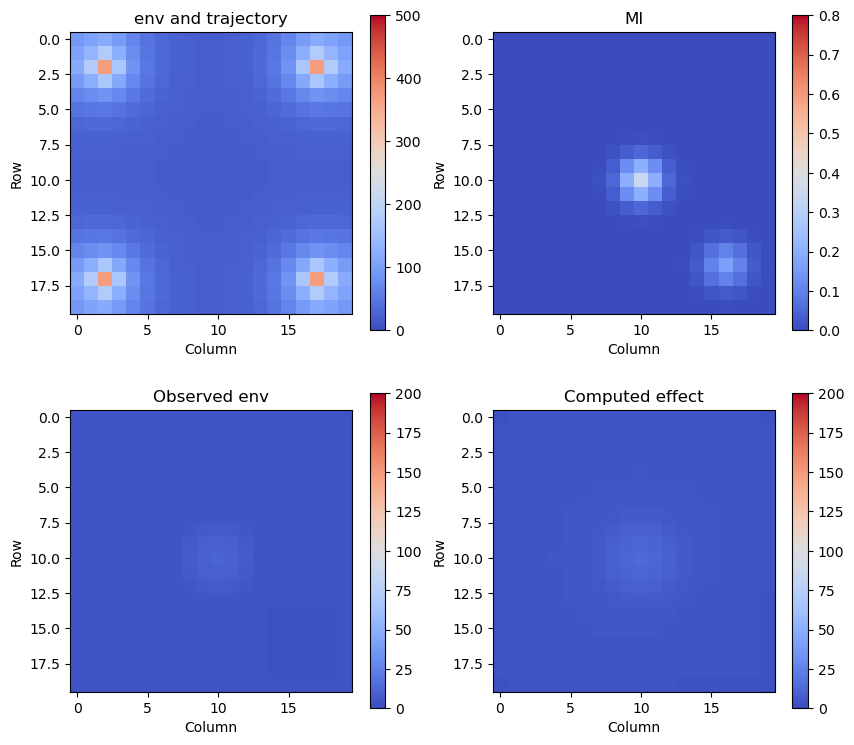

In [16]:
from pypolo2.experiments import visualizer
ani = visualizer.visual(logger)

# Display the animation
from IPython.display import HTML
HTML(ani.to_jshtml())

In [17]:
import math
import numpy as np
Temp = 2500
k = math.pow(0.00002, 1 / 10)
k = math.pow(k, 1)
delta_e_2 = -70
accept_prob = np.exp(delta_e_2 / (k * Temp))
print(k)
print(accept_prob)

0.3389245277339831
0.9207062293841938
